# YOLO v9を試す
今回の課題は物体検出タスクである。  
渋谷交差点を定点カメラから撮影した画像を1分ごとに撮影したものだが、実際に用いる際はリアルタイム性が必要だと判断しYOLO v9をベースとして用いる。

In [3]:
from ultralytics import YOLO

model = YOLO("yolov9c.pt")

### 物体検出

In [5]:
from collections import defaultdict
from enum import Enum


class ObjectType(Enum):
    """YOLOv9上で利用する番号の列挙型
    
    ex. `ObjectType.person.value` で　`0` が取得できる
    
    """
    person = 0
    bicycle = 1
    car = 2
    motorcycle = 3
    bus = 5
    truck = 7


def prepare_dict() -> dict[int, int]:
    return {hour: 0 for hour in range(24)}


# CSVファイルのヘッダーを作成しておく
csv_path = "../doc/predict.csv"
with open(csv_path, "w") as f:
    f.write("file_name,persons,bicycles,cars,motorcycles,buses,trucks\n")

sum_dict: dict[str, dict[int, int]] = {
    ObjectType.person.name: prepare_dict(),
    ObjectType.bicycle.name: prepare_dict(),
    ObjectType.car.name: prepare_dict(),
    ObjectType.motorcycle.name: prepare_dict(),
    ObjectType.bus.name: prepare_dict(),
    ObjectType.truck.name: prepare_dict(),
}

# 1時間ごとに集計して合計値を辞書に格納する
for h in range(24):
    for m in range(60):

        pic_path = f"../data/20240512/20240512_{str(h).zfill(2)}{str(m).zfill(2)}00.jpg"
        results = model(pic_path, save=True, exist_ok=True, show=False, conf=0.55)

        persons, bicycles, cars, motorcycles, buses, trucks = 0, 0, 0, 0, 0, 0
        for target in results[0].boxes.cls:
            if int(target) == ObjectType.person.value:
                sum_dict[ObjectType.person.name][h] += 1
                persons += 1
            if int(target) == ObjectType.bicycle.value:
                sum_dict[ObjectType.bicycle.name][h] += 1
                bicycles += 1
            if int(target) == ObjectType.car.value:
                sum_dict[ObjectType.car.name][h] += 1
                cars += 1
            if int(target) == ObjectType.motorcycle.value:
                sum_dict[ObjectType.motorcycle.name][h] += 1
                motorcycles += 1
            if int(target) == ObjectType.bus.value:
                sum_dict[ObjectType.bus.name][h] += 1
                buses += 1
            if int(target) == ObjectType.truck.value:
                sum_dict[ObjectType.truck.name][h] += 1
                trucks += 1
        # 当該の時間に検出できなかったものの辞書の値は0として扱う
        if persons == 0:
            sum_dict[ObjectType.person.name][h] = 0
        if bicycles == 0:
            sum_dict[ObjectType.bicycle.name][h] = 0
        if cars == 0:
            sum_dict[ObjectType.car.name][h] = 0
        if motorcycles == 0:
            sum_dict[ObjectType.motorcycle.name][h] = 0
        if buses == 0:
            sum_dict[ObjectType.bus.name][h] = 0
        if trucks == 0:
            sum_dict[ObjectType.truck.name][h] = 0

        # 処理したファイルで検出された物体の数をCSVに追記する
        with open(csv_path, "a") as f:
            f.write(f"20240512/20240512_{str(h).zfill(2)}{str(m).zfill(2)}00.jpg,{persons},{bicycles},{cars},{motorcycles},{buses},{trucks}\n")


image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000000.jpg: 384x640 2 cars, 706.2ms
Speed: 2.0ms preprocess, 706.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to F:\src\JPT\shibuya-scramble\runs\detect\predict

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000100.jpg: 384x640 5 cars, 667.6ms
Speed: 1.0ms preprocess, 667.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to F:\src\JPT\shibuya-scramble\runs\detect\predict

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000200.jpg: 384x640 2 cars, 1 tv, 685.1ms
Speed: 1.0ms preprocess, 685.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to F:\src\JPT\shibuya-scramble\runs\detect\predict

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\20240512\20240512_000300.jpg: 384x640 6 cars, 1 truck, 1 tv, 686.2ms
Speed: 1.0ms preprocess, 686.2ms inference, 1.

### 20240512の概要

In [13]:
print(f"時間帯ごとの小計:")
for k, v in sum_dict.items():
    print(f"[{k:10}], {dict(v)}")
    print(f"[{k:10}の合計] {sum(v.values()):4}\t[1時間あたりの平均台数] {sum(v.values()) / len(v):7.2f}")

時間帯ごとの小計:
[person    ], {0: 2, 1: 0, 2: 3, 3: 0, 4: 2, 5: 6, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}
[person    の合計]   14	[1時間あたりの平均台数]    0.58
[bicycle   ], {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}
[bicycle   の合計]    0	[1時間あたりの平均台数]    0.00
[car       ], {0: 42, 1: 342, 2: 20, 3: 0, 4: 155, 5: 8, 6: 2, 7: 5, 8: 1, 9: 31, 10: 43, 11: 0, 12: 59, 13: 111, 14: 50, 15: 129, 16: 103, 17: 212, 18: 22, 19: 32, 20: 8, 21: 0, 22: 17, 23: 30}
[car       の合計] 1422	[1時間あたりの平均台数]   59.25
[motorcycle], {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0}
[motorcycleの合計]    0	[1時間あたりの平均台数]    0.00
[bus       ], {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 3, 8: 0, 9: 5, 10: 12, 11: 12, 12: 9, 13: 21

(0.0, 24.0)

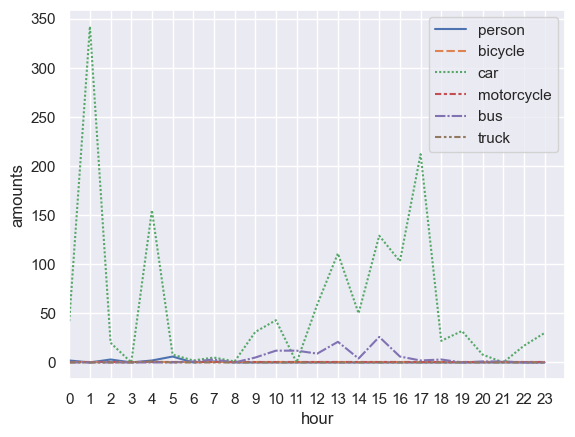

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

sns.set()

df = pd.DataFrame({k: v.values() for k, v in sum_dict.items()})
ax = sns.lineplot(data=df)

# 日本語の表示ができないため、英語を使う
ax.set_xlabel("hour")
ax.set_ylabel("amounts")

# 横軸を1時間刻みにして0-23時の間を表示する
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
ax.set_xticks(range(24))
ax.set_xticklabels([f"{str(i)}" for i in range(24)])
plt.xlim(0, 24)

20240512に存在する画像から物体検出を行った。
/runs に生成された画像を確認すると、正誤はともかく `cars`/`trucks`/`bus`/`motorcycles` などが検出できている。  
このままで顧客の要件を満たすかわからないため、目視で確認した範囲で見つけた　`乗用車`/`タクシー`/`バス`/`ゴミ収集車`/`トラック`/`救急車`/`パトカー`/`原付` を分類する方が望ましいか顧客に確認を行う。(依頼: 2024/06/03)


In [12]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 2.,  2.,  2.,  2.,  2.,  2.,  2., 62.])
conf: tensor([0.8328, 0.7948, 0.7751, 0.7239, 0.7093, 0.7076, 0.6969, 0.5806])
data: tensor([[2.4772e+02, 1.1513e+02, 3.0480e+02, 1.6008e+02, 8.3283e-01, 2.0000e+00],
        [4.9505e+02, 3.7752e+02, 5.9677e+02, 4.4270e+02, 7.9480e-01, 2.0000e+00],
        [3.0205e+02, 1.6473e+02, 3.6058e+02, 2.0996e+02, 7.7513e-01, 2.0000e+00],
        [3.6346e+02, 1.5538e+02, 4.1836e+02, 2.0101e+02, 7.2394e-01, 2.0000e+00],
        [9.3815e+02, 5.4476e+02, 1.0425e+03, 6.3433e+02, 7.0935e-01, 2.0000e+00],
        [0.0000e+00, 4.0002e+02, 8.4933e+01, 4.5510e+02, 7.0759e-01, 2.0000e+00],
        [2.0748e+02, 8.7475e+01, 2.5322e+02, 1.3114e+02, 6.9686e-01, 2.0000e+00],
        [5.5341e+02, 4.1734e+01, 7.0533e+02, 1.5008e+02, 5.8059e-01, 6.2000e+01]])
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([8, 6])
xywh: tensor([[276.2595, 137.6049,  57.0725,  44.9407],
        [545.90